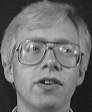

In [3]:
#Dependencies
import random
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


#Check an image
base_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'
img_x = 's2\\4.pgm'
#img = Image.open('C:\\Users\\..atnt_faces\\s2\\4.pgm')
Image.open(base_path + img_x)

In [18]:
def get_pairs(start, finish):
    sim_pairs = []
    diff_pairs=[]
    apn = []
    #root_path = 'C:\\Users\\...\\atnt_faces\\'

    
    folder_list = [i  for i  in range(start, finish)]
    
    for i in range(start, finish):

        folder_list_new = folder_list.copy()
        
        #Not to repeat the person in diff_pairs, remove ith folder in the new_list
        folder_list_new.remove(i)
        

        for  j in range(1, 11):
            
            #random.sample selects rand index --> selects rand img
            idx = random.sample(range(1, 11), 2)
            diff_person = random.sample(folder_list_new, 1)

            sim_pairs.append(['s' + str(i) + '\\' + str(idx[0])+ '.pgm', 
                              's' + str(i) + '\\' + str(idx[1])+ '.pgm', 1])

            diff_pairs.append(['s' + str(i) + '\\' + str(idx[0])+ '.pgm', 
                               's' + str(diff_person[0]) + '\\' + str(idx[1])+ '.pgm', 0])
            
            apn.append(['s' + str(i) + '\\' + str(idx[0])+ '.pgm', 
                        's' + str(i) + '\\' + str(idx[1]) + '.pgm', 
                        's' + str(diff_person[0]) + '\\' + str(idx[1])+ '.pgm'])
    return(sim_pairs, diff_pairs, apn)


In [19]:
sim_pairs, diff_pairs, triplets = get_pairs(4, 41)

In [20]:
sim_pairs[:2],  diff_pairs[:2], triplets[:2], len(triplets)

([['s4\\10.pgm', 's4\\7.pgm', 1], ['s4\\8.pgm', 's4\\9.pgm', 1]],
 [['s4\\10.pgm', 's27\\7.pgm', 0], ['s4\\8.pgm', 's39\\9.pgm', 0]],
 [['s4\\10.pgm', 's4\\7.pgm', 's27\\7.pgm'],
  ['s4\\8.pgm', 's4\\9.pgm', 's39\\9.pgm']],
 370)

In [9]:
#given list of pairs or triplets and batch size it finds total number of batches
def get_num_batches(the_list, batch_size):
    list_length = len(the_list)
    
    if list_length % batch_size ==0:
        num_batches = list_length//batch_size
    else:
        num_batches = list_length//batch_size + 1
    return num_batches

#given list of pairs, batch size, num_batches it retrieves all the pairs that belongs to i_th batch 
def get_batch(i, batch_size, num_batches, the_list):
    
    if i < num_batches-1:
    
        cur_batch = the_list[i*batch_size:i*batch_size + batch_size ]
        
    else:
        cur_batch = the_list[i*batch_size: ]
                
    return (cur_batch)

In [14]:
# _, _, triplets = get_pairs(4, 41)
# print(len(triplets))
#370 total triplets for 370 images in folder 4 to 4
 
batch_size = 50
num_batches = get_num_batches(triplets, batch_size)
print (num_batches)
# 8 

first_batch = get_batch(0, batch_size, num_batches, triplets)
print (first_batch[:2])
#[['s4\\5.pgm', 's4\\9.pgm', 's40\\9.pgm'],  ['s4\\2.pgm', 's4\\4.pgm', 's24\\4.pgm']]
#prints triplets of anchor anchor, positive and negative samples


8
[['s4\\6.pgm', 's4\\8.pgm', 's22\\8.pgm'], ['s4\\9.pgm', 's4\\5.pgm', 's7\\5.pgm']]


In [21]:
def get_input_tensors(cur_batch):
    
    from torchvision.transforms import ToTensor
    
    #3 tensors are initialized and to each respective image tensors are added
    batch_imgs_anc = torch.Tensor()
    batch_imgs_pos = torch.Tensor()
    batch_imgs_neg = torch.Tensor()
    
    #root_path is simply directories 
    #root_path = 'C:\\Users\\...\\atnt_faces\\'
    root_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'


    #cur_batch is subset of triplets with length of batch_size
    #cur_batch has 3 items in each sublist -->[0]: anchor, [1]:positive, [2]:negative samples
    for i in range(len(cur_batch)):
        file_path_anc = cur_batch[i][0]
        file_path_pos = cur_batch[i][1]
        file_path_neg = cur_batch[i][2]
        new_tensor_anc = ToTensor()(Image.open(root_path + file_path_anc)).unsqueeze(0)
        new_tensor_pos = ToTensor()(Image.open(root_path + file_path_pos)).unsqueeze(0)
        new_tensor_neg = ToTensor()(Image.open(root_path + file_path_neg)).unsqueeze(0)
        batch_imgs_anc = torch.cat((batch_imgs_anc, new_tensor_anc), dim =0)
        batch_imgs_pos = torch.cat((batch_imgs_pos, new_tensor_pos), dim =0)
        batch_imgs_neg = torch.cat((batch_imgs_neg, new_tensor_neg), dim =0)
        
        
    return(batch_imgs_anc, batch_imgs_pos, batch_imgs_neg)

In [22]:
cur_batch = get_batch(0, batch_size, num_batches, triplets)  #First batch from the triplets

batch_imgs_anc, batch_imgs_pos, batch_imgs_neg = get_input_tensors(cur_batch)
print(len(batch_imgs_anc))
#50 -->tensors corresponding to batch size of 50

print(batch_imgs_anc.shape)
#torch.Size([50, 1, 112, 92]) --> 50 images of size 112 x 92

print(batch_imgs_anc[0])
#outputs the tensor for first anchor image#

50
torch.Size([50, 1, 112, 92])
tensor([[[0.4667, 0.4863, 0.4627,  ..., 0.4471, 0.4510, 0.4784],
         [0.4745, 0.4784, 0.4667,  ..., 0.4431, 0.4510, 0.4510],
         [0.4784, 0.4706, 0.4784,  ..., 0.4392, 0.4588, 0.4471],
         ...,
         [0.3569, 0.3882, 0.5020,  ..., 0.3020, 0.3137, 0.3020],
         [0.3529, 0.3608, 0.4863,  ..., 0.3098, 0.3059, 0.3098],
         [0.3373, 0.3608, 0.4745,  ..., 0.2941, 0.3020, 0.3216]]])


In [23]:
#Convolutional neural network takes input tenors of size (1, 112, 92)
conv_net =nn.Sequential(nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1), 
                        nn.BatchNorm2d(4), 
                        nn.MaxPool2d(2),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(8),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
#Dense neural network takes input tenors of size (1, 16*56*46) and final output is 20 dimensional vector
dense_net = nn.Sequential(nn.Linear(16*56*46, 500),
                            nn.Linear(500, 128),
                         nn.Linear(128, 20))

#Adam is used for optimization, note the optimizer takes parameters from both networks to be updated at each step
LR = 0.0001
optimizer = torch.optim.Adam(([p for p in conv_net.parameters()] + [p for p in dense_net.parameters()]), lr=LR)

##############################################################################################################

#Forward function simply computes output for a given input tensor using above network defined above
def forward(inp, conv_net, dense_net):
    
    x = conv_net(inp)
    x = x.reshape(-1, 16*56*46)
    x = dense_net(x)
    
    # +/- normalize the vectors so that they become unit vectors
    #which makes it much easier to work with margins
    x = x / x.norm(2, dim =1).reshape(-1, 1)
    
    return x

In [24]:
forward(batch_imgs_anc[0].unsqueeze(0), conv_net, dense_net)

tensor([[-0.0179, -0.0653,  0.3109,  0.2927,  0.0992, -0.1634, -0.0875,  0.1107,
          0.0406, -0.0194, -0.2415, -0.1872, -0.5898,  0.0696,  0.3154,  0.2397,
          0.2871, -0.2148, -0.1383,  0.0626]], grad_fn=<DivBackward0>)

In [26]:
#Training in a single network for 10 epochs in less than 5 mins, on cpu
#Not used twin networks, same network takes all the constraints and outputs desired embedding
epochs = 6
print_every = 1
batch_size = 50
losses = []                                #collect the losses
margin = 0.2                               #margin may be tweaked as outputs are not normalized
#root_path = 'C:\\Users\\...\\atnt_faces\\' #use base path as per your directory chain
root_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'


_, _, triplets = get_pairs(start = 4 , finish =41)    #gets the triplets of anc, pos and neg
num_batches = get_num_batches(triplets, batch_size)   #gets num_baches given the trplets length 
semi_hard_len = []                                    #Check what proportion of easy ones are filtered

#.train() and .eval() are important as we will be training and testing in tandem
conv_net.train()                             
dense_net.train()

for e in range(epochs):
    
    #Generate  fresh triplets for each epoch and shuffle
    _, _, triplets = get_pairs(start = 4 , finish =41) 
    random.shuffle(triplets)
    
    for i in range(num_batches):        
        #get subset of triplets--> batch 0 to batch n (max of num_batches)
        cur_batch = get_batch(i, batch_size, num_batches, triplets)
        
        #######USE FOR MINING HARD AND SEMI HARD NEGATIVES #####################
        #cur_batch = mine_semi_hard(cur_batch, conv_net, dense_net, margin = 0.6)
        #semi_hard_len.append(len(cur_batch))    #see  how many samples are filterd in each batch
        #########################################################################
        
        
        
        
        #Transform batch of images to tensors
        batch_imgs_anc, batch_imgs_pos, batch_imgs_neg = get_input_tensors(cur_batch)    
        
        #Forward all anchor, pos, neg and get respective vectors
        anc_fc_out = forward(batch_imgs_anc, conv_net, dense_net)           
        pos_fc_out = forward(batch_imgs_pos, conv_net, dense_net)        
        neg_fc_out = forward(batch_imgs_neg, conv_net, dense_net)
        
        #squared dist is used in place of euclidean distance as it trains better
        pos_dist = torch.sum(torch.mul(anc_fc_out - pos_fc_out, anc_fc_out - pos_fc_out), dim =1)
        neg_dist = torch.sum(torch.mul(anc_fc_out - neg_fc_out, anc_fc_out - neg_fc_out), dim =1)
        total_loss = torch.sum(torch.max((pos_dist - neg_dist + margin), 
                                         torch.Tensor([0]).reshape(1, -1)))
        
        
        losses.append(total_loss.item())        #collect losses
        optimizer.zero_grad()                   #Flush grads from previous  operations 
        total_loss.backward()                   #Get grads
        optimizer.step()                        #Adjust parameters, grads are tweaked by Adam 
        
        
    
    if e % print_every == 0:
        print(total_loss.item())

0.0
0.26017361879348755
0.0
0.0
0.0
0.4209820628166199


In [69]:
#FOR TEST ONLY
#For test we want images, tensors, embeds in order so that we know which one is which

def get_test_pairs(start, finish):
    test_pairs =[]
    
    folder_list = [i  for i  in range(start, finish)]
    
    for i in range(start, finish):

        folder_list_new = folder_list.copy()        

        for  j in range(1, 11):            

            test_pairs.append(['s' + str(i) + '\\' + str(j) + '.pgm']*3)
           
    return(test_pairs)

In [78]:
def test_norm(conv_net, dense_net, start, finish,  margin = 0.1):
    
    #margin here is different from margin while training. Here margin is cut off value, 
    #or upper bound for sepaeating same and diffrent person
    #margin set at training aims to keep pos and neg distances away by set margin
    #note fucntion has default margin of 0.1
    #Keep in evaluation mode
    conv_net.eval()
    dense_net.eval()
    
    #Get desired pairs of images --> transformation to tesors --> to network --> get embedding
    #NOTE: get_test_pairs is use in  place of get_pairs
    test_batch = get_test_pairs(start, finish)
    test_imgs_anc, test_imgs_pos, test_imgs_neg = get_input_tensors(test_batch)
    embeds = forward(test_imgs_pos, conv_net, dense_net)
    
    ############################################################################################
    ###Note that embeddings are normalized so that margins remain low and vectors become unit vectors
    ####This step is redundant if vectors are already normalized in forward furction
    
    #embeds = embeds/embeds.norm(2)
    ###########################################################################################
    

    #Initialize right sized matrix with zeros and replace each cell by corresponding distance
    # cell i, j represents the distance between i_th and j_th images
    sim_matrix = np.zeros((len(embeds), len(embeds)))
    
    #sim_matrix_bounded is a smoothed matrix where all values below selected cut off is made 0
    #All true positive are supposed to have shorter distance and vice versa
    #Which helps to gauge the performance (true pos and false neg are readily visualized)
    #Selecting cut - off : Either use some search algorithm or by eye balling - actual matrix  or heatmaps
    sim_matrix_bounded = np.zeros((len(embeds), len(embeds)))
    j = 0
    for i in range(len(embeds)):
        ref_img = embeds[i]
        for j in range(len(embeds)):

            dist = (ref_img - embeds[j]).norm(2).item()
            
            sim_matrix[j, i] = dist
            if dist < margin:
                sim_matrix_bounded[j, i] = 0
            else:
                sim_matrix_bounded[j, i] = dist
            
    return (sim_matrix, sim_matrix_bounded)

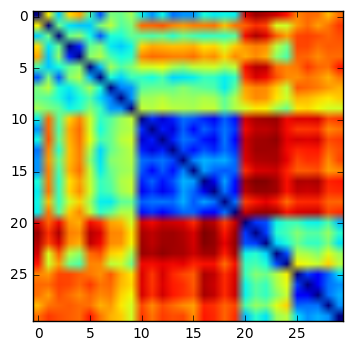

In [79]:
sim_matrix, sim_matrix_bounded = test_norm(conv_net, dense_net, 1, 4,  margin = 0.1)
plt.imshow(sim_matrix)

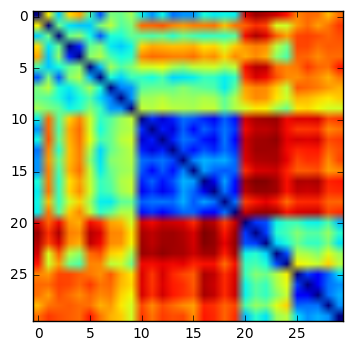

In [74]:
#Embeds not re-normalized
sim_matrix, sim_matrix_bounded = test_norm(conv_net, dense_net, 1, 4,  margin = 0.5)
plt.imshow(sim_matrix)

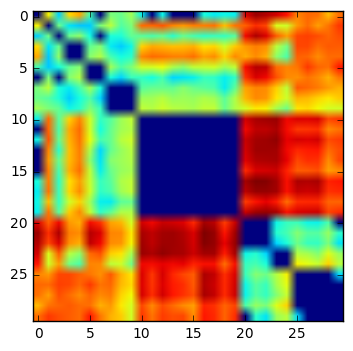

In [75]:
plt.imshow(sim_matrix_bounded)

In [77]:
get_test_pairs(1, 4)[:5]

[['s1\\1.pgm', 's1\\1.pgm', 's1\\1.pgm'],
 ['s1\\2.pgm', 's1\\2.pgm', 's1\\2.pgm'],
 ['s1\\3.pgm', 's1\\3.pgm', 's1\\3.pgm'],
 ['s1\\4.pgm', 's1\\4.pgm', 's1\\4.pgm'],
 ['s1\\5.pgm', 's1\\5.pgm', 's1\\5.pgm']]

In [54]:
#Finding accuracy and other metrics over a range of cut off values

def test_accuracy_metrics_plot(test_mtx):
    
    #margin = 0.1
    cache = []
    cache_same = []      #Cache that collects all values in diagonal region, corresponding to  same individuals 
    cache_diff = []      #Cache that collects all values rest region, corresponding to  diff individuals
    means =[]            #means and max values are used to set range over which accuracies are calculated
    maxs = []
    counts = int(test_mtx.shape[0]/10)
    for i in range(counts):
        for j  in range(counts):

            var_name = 'new' + str(i) +str(j)

            var_name_mtx = test_mtx[i*10:i*10 + 10, j*10:j*10 +10]

            cache.append([var_name, var_name_mtx])
            if i ==j:
                cache_same.append([var_name, var_name_mtx])
                means.append(np.mean(var_name_mtx))
                maxs.append(np.max(var_name_mtx))
            else:
                cache_diff.append([var_name, var_name_mtx])
                
    lower_bound = np.min(means)
    upper_bound = np.max(maxs)
    steps = (upper_bound - lower_bound)/100
    
    #list of cut off values for which all metrics calculated, used to select best margin
    margins = list(np.arange(lower_bound, upper_bound, steps))  
    
    
    metrics = []
    samples = test_mtx.shape[0]*test_mtx.shape[0]
    a_true = np.sqrt(samples)*10                #Actual true,  here 300/900 are actual true
    a_neg = samples - a_true                    #Actual false, here 600/900 are actually false
    
    for j in range(len(margins)):
    
        f_pos = 0                                   #false pos
        for i in range(len(cache_diff)):
            f_pos += np.sum(cache_diff[i][1] < margins[j])
            
        true_test_pos = 0                           #true pos
        for i in range(len(cache_same)):
            true_test_pos += np.sum(cache_same[i][1] < margins[j])
            

        cor_neg = a_neg-f_pos                       #correctly identified negative or true negative
        accu = (true_test_pos + cor_neg)/samples    #(true pos + true neg) / sample size

        f_neg = a_true - true_test_pos              #false neg
        prec= true_test_pos/(true_test_pos+f_pos)   #precision
        rec = true_test_pos/(true_test_pos +f_neg)  #reacall
        f1_score = 2 * prec * rec/(prec+rec)        #f1 score
        metrics.append([margins[j], accu, prec, rec, f1_score])
    #tp, fp, samples, prec, rec, 'f1 score is:', f1_score, 'accu=',  accu   
   
    
    return (metrics)

#test_mtx, _ = test_norm(conv_net, dense_net, start = 1 , finish =41,  margin = 0.022)
#metrics =test_accuracy_metrics_plot(test_mtx)

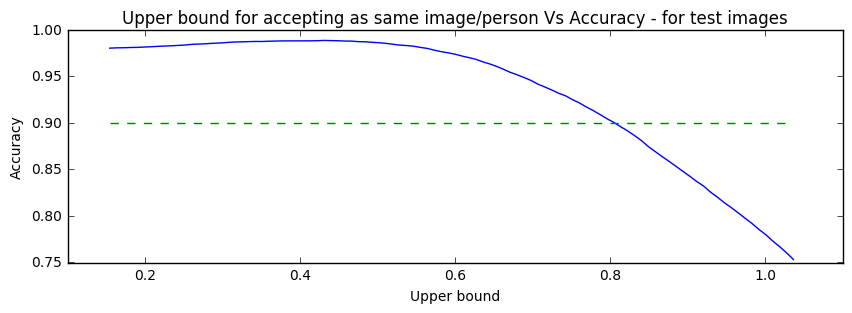

In [55]:
test_mtx, _ = test_norm(conv_net, dense_net, start = 1 , finish =41,  margin = 0.022)

#metrics consist of list of lists with items arranged as [margins, accu, prec, rec, f1_score]
metrics_for_test = test_accuracy_metrics_plot(test_mtx)

plt.figure(figsize=(10, 3))
plt.plot(np.array(metrics_for_test)[:,0], np.array(metrics_for_test)[:,1])
plt.plot(np.array(metrics_for_test)[:,0], [(0.90) for i  in range(len(metrics_for_test))], '--')
plt.title('Upper bound for accepting as same image/person Vs Accuracy - for test images')
plt.ylabel('Accuracy')
plt.xlabel('Upper bound')
plt.show()

In [59]:
#Select and sort accuracy, last index correxponds to highest accuracy
best_accu_index = np.argsort(np.array(metrics_for_test)[:,1])[-1] 

In [60]:
metrics_for_test[best_accu_index]  #prints margin, best accuracy, precision, recall and f1 score

[0.43074082609415043, 0.9888, 0.8301435406698564, 0.694, 0.7559912854030499]

In [82]:
#get triplets for all available images --> get tensors --> forward and get embedding for all images
#Save emdiing in order in a list(together with with name and index)
def get_look_up_list(start, finish, conv_net, dense_net):
    all_imgs_triplets = get_test_pairs(start, finish)
    _, _, cluster_tensors = get_input_tensors(all_imgs_triplets)
   
    conv_net.eval()
    dense_net.eval()
    serial_embeds = forward(cluster_tensors, conv_net, dense_net)
    look_up_list = []
    for i in range(len(serial_embeds)):
        look_up_list.append([i, all_imgs_triplets[i][0], serial_embeds[i]])
    return (look_up_list)

In [83]:
look_up_list = get_look_up_list(1, 41, conv_net, dense_net)
print(look_up_list[0])

[0, 's1\\1.pgm', tensor([-0.1826, -0.3878, -0.0073,  0.2497, -0.0427,  0.4357, -0.3130,  0.0958,
        -0.1001,  0.0543, -0.1535, -0.2004, -0.2293,  0.3881,  0.1689,  0.0041,
        -0.2248,  0.0957,  0.2920, -0.0401], grad_fn=<SelectBackward>)]


'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'

In [85]:
#selecte_img is the index of desired image in look_up_list
def find_person(selected_img, look_up_list):
    #base_path = 'C:\\Users\\...\\atnt_faces\\'
    base_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'
    selected_img_emb = look_up_list[selected_img][2]
    dists_from_selected_img =[]
    
    #Compute and collect distance from selected to all images    
    for j in range(len(look_up_list)):
        
        dist = (selected_img_emb.detach() - look_up_list[j][2].detach()).norm(2).item()
        
        dists_from_selected_img.append(dist)
     
    #Reshaped such that each row contains distances to single person
    dists_to_each = np.array(dists_from_selected_img).reshape(-1, 10)
    
    #better to correct mean for group belonging to selected_img as --> as dist to itself if 0
    #just increase the mean by mean x 10/9, but it is left out here
    mean_dists_to_each = np.mean(dists_to_each, axis=1)
    dists_ordered = np.argsort(mean_dists_to_each)
    closest_person = dists_ordered[0]
    
    #Open and plot images    
    img_given = Image.open(base_path + look_up_list[selected_img][1])
    
    #grouping above for mean scales down --> therefore x10 takes to right person
    img_found = Image.open(base_path + look_up_list[closest_person*10][1]) 
    imgs = [img_given, img_found]

        
    titles = ['Given image', 'Idenified person']
    
    f,ax = plt.subplots(1,2, figsize=(4,4))
    for i in range(2):
        plt.axis('off')
        ax[i].imshow(imgs[i], cmap='gray', )
        
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    
    plt.show()
    #If nam of person is known, print name
    #print('Identified person is', names[closest_person], ' in folder - ' + 'S'+ str(closest_person), )
    return (mean_dists_to_each)

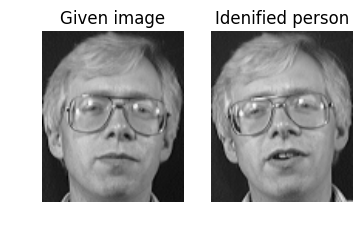

array([0.89915437, 0.24623849, 1.40480736, 1.33066083, 1.62849771,
       1.41435592, 0.87803077, 0.81626312, 1.61251076, 1.35037916,
       0.59056972, 1.63431268, 1.2315311 , 0.85301907, 1.04345673,
       0.46334697, 1.00861799, 1.32431773, 0.58127128, 1.13923682,
       1.46194084, 1.0527679 , 1.52130461, 0.83202246, 1.54659908,
       1.62023422, 0.4725906 , 1.19090982, 1.4773685 , 1.42314241,
       1.5581555 , 0.89464784, 1.3679505 , 1.29450277, 1.59522836,
       0.72607619, 1.2125357 , 1.30265826, 1.34485011, 1.68174347])

In [88]:
find_person(11, look_up_list)

In [89]:
np.argsort(np.array([0.89915437, 0.24623849, 1.40480736, 1.33066083, 1.62849771,
       1.41435592, 0.87803077, 0.81626312, 1.61251076, 1.35037916,
       0.59056972, 1.63431268, 1.2315311 , 0.85301907, 1.04345673,
       0.46334697, 1.00861799, 1.32431773, 0.58127128, 1.13923682,
       1.46194084, 1.0527679 , 1.52130461, 0.83202246, 1.54659908,
       1.62023422, 0.4725906 , 1.19090982, 1.4773685 , 1.42314241,
       1.5581555 , 0.89464784, 1.3679505 , 1.29450277, 1.59522836,
       0.72607619, 1.2125357 , 1.30265826, 1.34485011, 1.68174347]))

array([ 1, 15, 26, 18, 10, 35,  7, 23, 13,  6, 31,  0, 16, 14, 21, 19, 27,
       36, 12, 33, 37, 17,  3, 38,  9, 32,  2,  5, 29, 20, 28, 22, 24, 30,
       34,  8, 25,  4, 11, 39], dtype=int64)

In [92]:
#look up already has full complements of embedding, the 3rd item of each sublist
# n --> num of imgs to be pooled, ref_img_idx --> index of selected image in look_up_list
def find_cluster(n, look_up_list,  ref_img_idx):
    ref_img_embed = look_up_list[ref_img_idx][2]
    dists_from_ref =[]
    
    for j in range(len(look_up_list)):

        dist = (ref_img_embed.detach() - look_up_list[j][2].detach()).norm(2).item()

        dists_from_ref.append(dist)
    
    #collect n images having shortest distances, first image will be itself
    cluster_of_imgs = np.argsort(dists_from_ref)[:n]
    

    fig=plt.figure(figsize=(8, 4))
    columns = 4
    rows = 2
    #base_path = 'C:\\Users\\..\\atnt_faces\\'
    base_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'
    
    for i in range(1, n+1):
        img = Image.open(base_path + look_up_list[cluster_of_imgs[i-1]][1])
        plt.axis('off')
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap= 'gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    plt.show()

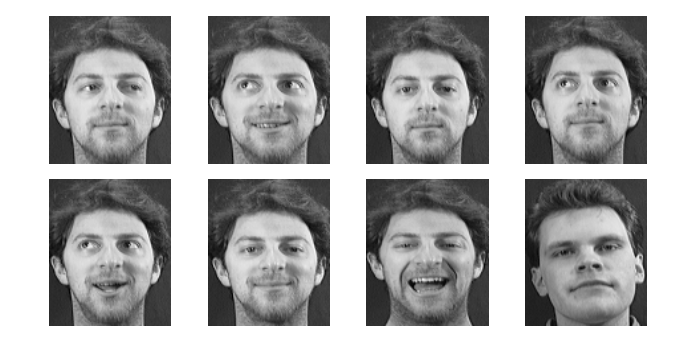

In [93]:
find_cluster(8, look_up_list,  66)

In [100]:
#For current batch --> get tensors --> forward --> find pos, neg dist --> 
#check if: neg_dist< pos_dist + margin --> true: include all true pairs --> forward to get loss --> find grad/step
def mine_semi_hard(cur_batch, conv_net, dense_net, margin):
    #For this database of imags margin used was around 0.6
    #Probably using dynamic margins should work even better
    
    conv_net.eval()
    dense_net.eval()
    
    batch_imgs_anc, batch_imgs_pos, batch_imgs_neg = get_input_tensors(cur_batch)
    

    anc_fc_out = forward(batch_imgs_anc, conv_net, dense_net)

    pos_fc_out = forward(batch_imgs_pos, conv_net, dense_net)

    neg_fc_out = forward(batch_imgs_neg, conv_net, dense_net)
    

    pos_dist = (anc_fc_out - pos_fc_out).norm(2, dim =1) 
    
    neg_dist = (anc_fc_out - neg_fc_out).norm(2, dim =1) #- margin
    
    semi_hard_idx = (neg_dist < pos_dist + margin).nonzero()
    
    semi_hard_cur_batch = [cur_batch[i] for i in semi_hard_idx]   #weeds out easy ones
    
    conv_net.train()
    dense_net.train()
    return (semi_hard_cur_batch)

In [96]:
def gen_nn():
    #Convolutional neural network takes input tenors of size (1, 112, 92)
    conv_net =nn.Sequential(nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1), 
                            nn.BatchNorm2d(4), 
                            nn.MaxPool2d(2),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(8),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(16),
                            nn.ReLU())
    #Dense neural network takes input tenors of size (1, 16*56*46) and final output is 20 dimensional vector
    dense_net = nn.Sequential(nn.Linear(16*56*46, 500),
                                nn.Linear(500, 128),
                             nn.Linear(128, 20))

    #Adam is used for optimization, note the optimizer takes parameters from both networks to be updated at each step
    LR = 0.0001
    optimizer = torch.optim.Adam(([p for p in conv_net.parameters()] + [p for p in dense_net.parameters()]), lr=LR)
    return (conv_net, dense_net, optimizer)


In [98]:
conv_net_mine, dense_net_mine, optimizer_mine = gen_nn()

In [101]:
epochs = 6
print_every = 1
batch_size = 50
losses_mine = []                                #collect the losses
margin = 0.2                               #margin may be tweaked as outputs are not normalized
#root_path = 'C:\\Users\\...\\atnt_faces\\' #use base path as per your directory chain
root_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'


_, _, triplets = get_pairs(start = 4 , finish =41)    #gets the triplets of anc, pos and neg
num_batches = get_num_batches(triplets, batch_size)   #gets num_baches given the trplets length 
semi_hard_len = []                                    #Check what proportion of easy ones are filtered

#.train() and .eval() are important as we will be training and testing in tandem
conv_net.train()                             
dense_net.train()

for e in range(epochs):
    
    #Generate  fresh triplets for each epoch and shuffle
    _, _, triplets = get_pairs(start = 4 , finish =41) 
    random.shuffle(triplets)
    
    for i in range(num_batches):        
        #get subset of triplets--> batch 0 to batch n (max of num_batches)
        cur_batch = get_batch(i, batch_size, num_batches, triplets)
        
        #######USE FOR MINING HARD AND SEMI HARD NEGATIVES #####################
        cur_batch = mine_semi_hard(cur_batch, conv_net, dense_net, margin = 0.6)
        semi_hard_len.append(len(cur_batch))    #see  how many samples are filterd in each batch
        #########################################################################
        
        
        
        
        #Transform batch of images to tensors
        batch_imgs_anc, batch_imgs_pos, batch_imgs_neg = get_input_tensors(cur_batch)    
        
        #Forward all anchor, pos, neg and get respective vectors
        anc_fc_out = forward(batch_imgs_anc, conv_net_mine, dense_net_mine)           
        pos_fc_out = forward(batch_imgs_pos, conv_net_mine, dense_net_mine)        
        neg_fc_out = forward(batch_imgs_neg, conv_net_mine, dense_net_mine)
        
        #squared dist is used in place of euclidean distance as it trains better
        pos_dist = torch.sum(torch.mul(anc_fc_out - pos_fc_out, anc_fc_out - pos_fc_out), dim =1)
        neg_dist = torch.sum(torch.mul(anc_fc_out - neg_fc_out, anc_fc_out - neg_fc_out), dim =1)
        total_loss = torch.sum(torch.max((pos_dist - neg_dist + margin), 
                                         torch.Tensor([0]).reshape(1, -1)))
        
        
        losses_mine.append(total_loss.item())        #collect losses
        optimizer_mine.zero_grad()                   #Flush grads from previous  operations 
        total_loss.backward()                   #Get grads
        optimizer_mine.step()                        #Adjust parameters, grads are tweaked by Adam 
        
        
    
    if e % print_every == 0:
        print(total_loss.item())

0.6098688840866089
0.0
0.0
0.32456403970718384
0.04782132804393768
0.3207191228866577


In [108]:
#First find the perdicted id for an image
#Note min of mean(all_images_of_one_person) is used (NOT the min dist to all images in pool)
def true_id(selected_img, look_up_list):
    selected_img_emb = look_up_list[selected_img][2]
    dists_from_selected_img =[]
    
    for j in range(len(look_up_list)):
        
        dist = (selected_img_emb.detach() - look_up_list[j][2].detach()).norm(2).item()

        dists_from_selected_img.append(dist)
    dists_to_each = np.array(dists_from_selected_img).reshape(-1, 10)
    
    mean_dists_to_each = np.mean(dists_to_each, axis=1)
    dists_ordered = np.argsort(mean_dists_to_each)
    closest_person = dists_ordered[0]
    return (closest_person)

#Loop through all images checking whether predicted is corrct.
#Sum all corrct id_s and find accuracy
def find_acc(look_up_list):
    cor_count = 0
    ids_found = []
    for i in range(len(look_up_list)):
        id_of_person_i = true_id(i, look_up_list)
        ids_found.append([i, i // 10, id_of_person_i])
        if i // 10 == id_of_person_i:
            cor_count += 1

        
    accuracy = cor_count/len(look_up_list)
    print(accuracy)
    return(ids_found)


############################################################################################
#Alternative use min distance, which is less accurate

def true_id_min(selected_img, look_up_list):
    selected_img_emb = look_up_list[selected_img][2]
    dists_from_selected_img =[]
    
    for j in range(len(look_up_list)):
        
        dist = (selected_img_emb.detach() - look_up_list[j][2].detach()).norm(2).item()

        dists_from_selected_img.append(dist) 
        
    dists_ordered_min = np.argsort(dists_from_selected_img)
    #as the least distace will be with itself at position 0
    closest_person = dists_ordered_min[1]
    return (closest_person)

def find_acc_min(look_up_list):
    cor_count = 0
    ids_found_using_min = []
    for i in range(len(look_up_list)):
        id_of_person_i = true_id_min(i, look_up_list) //10
        ids_found_using_min.append([i, i // 10, id_of_person_i])
        if i // 10 == id_of_person_i:
            cor_count += 1

        #return (cor_count)
    #cor_count
    accuracy = cor_count/len(look_up_list)
    print(accuracy)
    return(ids_found_using_min)

In [110]:
find_acc_min(look_up_list)

0.9475


[[0, 0, 15],
 [1, 0, 17],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [5, 0, 31],
 [6, 0, 0],
 [7, 0, 0],
 [8, 0, 0],
 [9, 0, 0],
 [10, 1, 1],
 [11, 1, 1],
 [12, 1, 1],
 [13, 1, 1],
 [14, 1, 1],
 [15, 1, 1],
 [16, 1, 1],
 [17, 1, 1],
 [18, 1, 15],
 [19, 1, 1],
 [20, 2, 2],
 [21, 2, 2],
 [22, 2, 2],
 [23, 2, 25],
 [24, 2, 2],
 [25, 2, 2],
 [26, 2, 2],
 [27, 2, 2],
 [28, 2, 2],
 [29, 2, 3],
 [30, 3, 3],
 [31, 3, 3],
 [32, 3, 3],
 [33, 3, 3],
 [34, 3, 3],
 [35, 3, 3],
 [36, 3, 3],
 [37, 3, 3],
 [38, 3, 3],
 [39, 3, 3],
 [40, 4, 4],
 [41, 4, 4],
 [42, 4, 4],
 [43, 4, 4],
 [44, 4, 4],
 [45, 4, 4],
 [46, 4, 4],
 [47, 4, 4],
 [48, 4, 4],
 [49, 4, 4],
 [50, 5, 5],
 [51, 5, 5],
 [52, 5, 5],
 [53, 5, 5],
 [54, 5, 5],
 [55, 5, 5],
 [56, 5, 5],
 [57, 5, 5],
 [58, 5, 5],
 [59, 5, 5],
 [60, 6, 6],
 [61, 6, 6],
 [62, 6, 6],
 [63, 6, 6],
 [64, 6, 6],
 [65, 6, 6],
 [66, 6, 6],
 [67, 6, 6],
 [68, 6, 6],
 [69, 6, 6],
 [70, 7, 7],
 [71, 7, 7],
 [72, 7, 7],
 [73, 7, 7],
 [74, 7, 7],
 [75, 7, 7],
 [76, 7, 7],
 [77

In [112]:
look_up_list_mine = get_look_up_list(1, 41, conv_net_mine, dense_net_mine)

In [113]:
find_acc_min(look_up_list_mine)

0.94


[[0, 0, 0],
 [1, 0, 0],
 [2, 0, 7],
 [3, 0, 0],
 [4, 0, 0],
 [5, 0, 0],
 [6, 0, 0],
 [7, 0, 0],
 [8, 0, 0],
 [9, 0, 15],
 [10, 1, 1],
 [11, 1, 1],
 [12, 1, 1],
 [13, 1, 1],
 [14, 1, 1],
 [15, 1, 1],
 [16, 1, 1],
 [17, 1, 1],
 [18, 1, 1],
 [19, 1, 1],
 [20, 2, 2],
 [21, 2, 2],
 [22, 2, 2],
 [23, 2, 2],
 [24, 2, 24],
 [25, 2, 2],
 [26, 2, 2],
 [27, 2, 2],
 [28, 2, 3],
 [29, 2, 2],
 [30, 3, 3],
 [31, 3, 3],
 [32, 3, 3],
 [33, 3, 2],
 [34, 3, 3],
 [35, 3, 3],
 [36, 3, 3],
 [37, 3, 3],
 [38, 3, 3],
 [39, 3, 3],
 [40, 4, 4],
 [41, 4, 24],
 [42, 4, 39],
 [43, 4, 4],
 [44, 4, 4],
 [45, 4, 4],
 [46, 4, 39],
 [47, 4, 4],
 [48, 4, 4],
 [49, 4, 39],
 [50, 5, 5],
 [51, 5, 5],
 [52, 5, 5],
 [53, 5, 5],
 [54, 5, 5],
 [55, 5, 5],
 [56, 5, 5],
 [57, 5, 5],
 [58, 5, 5],
 [59, 5, 5],
 [60, 6, 6],
 [61, 6, 6],
 [62, 6, 6],
 [63, 6, 6],
 [64, 6, 6],
 [65, 6, 6],
 [66, 6, 6],
 [67, 6, 6],
 [68, 6, 6],
 [69, 6, 6],
 [70, 7, 7],
 [71, 7, 7],
 [72, 7, 7],
 [73, 7, 7],
 [74, 7, 7],
 [75, 7, 7],
 [76, 7, 7],
 [7

In [116]:
#losses_mine, losses

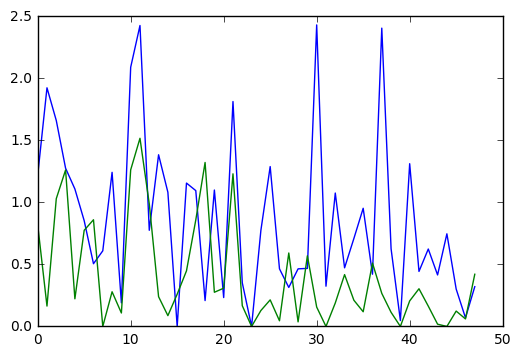

In [120]:
#As the triplets come randompy and every new epoch gets new batch of unseen triplets
#Loss spike up at the beginning to and goes down towards end of epoch
#Overall - loss trends downward
#Also note that it freqyently touches 0, implying network quickly learns the constraint
plt.plot(losses_mine)
plt.plot(losses)
plt.show()

In [130]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


def tsne_scatter_3d(look_up_list, title):
    embeds_selected = [i[2].detach().numpy() for i in look_up_list]
    tsne_model = TSNE(n_components =3, random_state = 0)
    emb_in_3d = tsne_model.fit_transform(embeds_selected)
    list_xs = emb_in_3d[:, 0]
    list_xs = [list_xs[i:i + 10] for i in range(0, len(list_xs), 10)]
    #list_xs
    list_ys = emb_in_3d[:, 1]
    list_ys = [list_ys[i:i + 10] for i in range(0, len(list_ys), 10)]
    
    list_zs = emb_in_3d[:, 2]
    list_zs = [list_zs[i:i + 10] for i in range(0, len(list_zs), 10)]
    colors =cm.rainbow(np.linspace(0, 1, len(list_ys)))
    
        
    #fig = plt.figure(figsize= (8, 6))   ##If bigger figuer size is needed
    fig = plt.figure()
    ax = Axes3D(fig)
    for x, y, z, c in zip(list_xs, list_ys, list_zs, colors):
        ax.scatter(x, y, z, color=c)
    plt.title(title)
    plt.show()

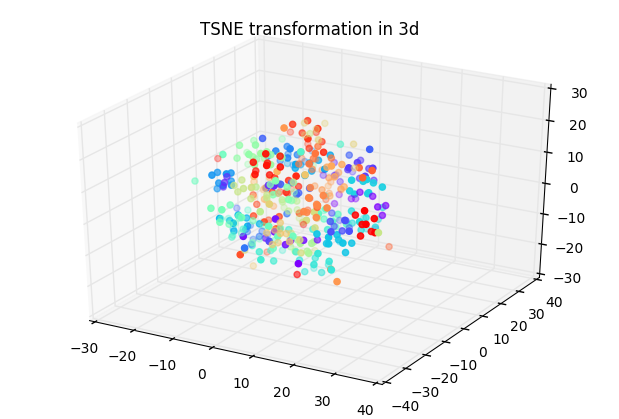

In [131]:
tsne_scatter_3d(look_up_list, 'TSNE transformation in 3d')

In [ ]:
#Contrastive loss

In [137]:
#sim_pairs, diff_pairs, triplets = get_pairs(start, finish) is already there
#sim_pairs --> pairs of images of same person, labeled 1
#diff_pairs --> pairs of images of different person, labeled 0
#get_comb_list --> combines the two lists then shuffled

def get_comb_list(start=4, finish = 41):
    
    #sim_pairs, diff_pairs, triplets = get_pairs_cor_labels(start, finish)
    sim_pairs, diff_pairs, triplets = get_pairs(start, finish)
    comb_list = sim_pairs + diff_pairs
    random.shuffle(comb_list)
    return (comb_list)


In [138]:
get_comb_list(start=4, finish = 41)[:2]

[['s4\\1.pgm', 's4\\9.pgm', 1], ['s4\\4.pgm', 's5\\2.pgm', 0]]

In [139]:
#Getting input tensors for the above pairs along with labels
#_cl:contrastive loss
def get_input_tensors_cl(cur_batch):
    
    from torchvision.transforms import ToTensor
    batch_imgs_anc = torch.Tensor()
    batch_imgs_pn = torch.Tensor()
    #batch_imgs_neg = torch.Tensor()
    labels = []
    #root_path = 'C:\\Users\\..\\atnt_faces\\'
    root_path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\face_recog\\ATNT faces\\atnt_faces\\'



    for i in range(len(cur_batch)):
        file_path_anc = cur_batch[i][0]
        file_path_pn = cur_batch[i][1]
        
        new_tensor_anc = ToTensor()(Image.open(root_path + file_path_anc)).unsqueeze(0)
        new_tensor_pn = ToTensor()(Image.open(root_path + file_path_pn)).unsqueeze(0)
        
        batch_imgs_anc = torch.cat((batch_imgs_anc, new_tensor_anc), dim =0)
        batch_imgs_pn = torch.cat((batch_imgs_pn, new_tensor_pn), dim =0)
        
        labels.append(cur_batch[i][2])
        
    return(batch_imgs_anc, batch_imgs_pn, labels)

In [191]:
conv_net_cl, dense_net_cl, optimizer_cl = gen_nn()

In [182]:
get_comb_list(start=4, finish = 41)[-5:]

[['s9\\6.pgm', 's9\\10.pgm', 1],
 ['s29\\3.pgm', 's29\\10.pgm', 1],
 ['s22\\2.pgm', 's39\\9.pgm', 0],
 ['s11\\10.pgm', 's11\\5.pgm', 1],
 ['s36\\4.pgm', 's36\\10.pgm', 1]]

In [192]:
#Finally Train
import torch.nn.functional as F
epochs = 15
print_every = 1

batch_size = 50
losses_cl = []

conv_net_cl.eval()
dense_net_cl.eval()

margin =0.25 

for e in range(epochs):
    comb_list = get_comb_list(start=4, finish = 41)
        
    num_batches = get_num_batches(comb_list, batch_size)
    
    for i in range(num_batches):
        cur_batch = get_batch(i, batch_size, num_batches, comb_list)
        
        batch_imgs_anc, batch_imgs_pn, labels = get_input_tensors_cl(cur_batch)
        labels = torch.Tensor(labels)

        
        anc_fc_out = forward(batch_imgs_anc, conv_net_cl, dense_net_cl)
        pn_fc_out = forward(batch_imgs_pn, conv_net_cl, dense_net_cl)
        
        
        euclidean_distance = F.pairwise_distance(anc_fc_out, pn_fc_out)
        loss_contrastive = torch.mean((labels) * torch.pow(euclidean_distance, 2) +
                                      (1-labels) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
        
        
#         if i % print_every ==0:
#             print(e, i, '........', loss_contrastive.item())
            
        
        losses_cl.append(loss_contrastive.item())
        
        optimizer_cl.zero_grad()
        
        loss_contrastive.backward()#(retrain_graph = True)
        optimizer_cl.step()
        
        
        
    if e % print_every == 0:
        print(loss_contrastive.item())

0.014537381939589977
0.0035481080412864685
0.003461357206106186
0.003876351984217763
0.006086037959903479
0.006297450512647629
0.0026427824050188065
0.003753402503207326
0.0042586131021380424
0.003548723179847002
0.002684063743799925
0.003592344466596842
0.0038520670495927334
0.00221280287951231
0.005127860698848963


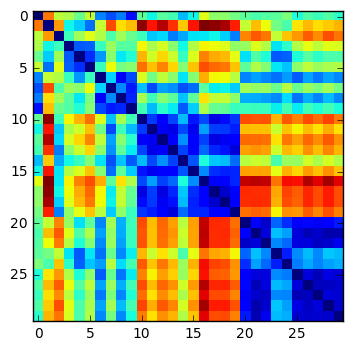

In [193]:
sim_matrix_cl, sim_matrix_bounded_cl = test_norm(conv_net_cl, dense_net_cl, 1, 4,  margin = 0.151)
plt.imshow(sim_matrix_cl, interpolation='nearest')

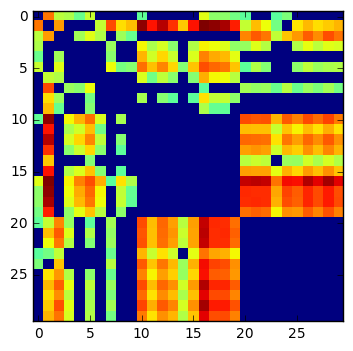

In [194]:
#interpolation='nearest'
plt.imshow(sim_matrix_bounded_cl, interpolation='nearest')
plt.show()

In [198]:
look_up_list_cl = get_look_up_list(1, 41, conv_net_cl, dense_net_cl)
find_acc_min(look_up_list_cl)[:30]

0.94


[[0, 0, 14],
 [1, 0, 4],
 [2, 0, 31],
 [3, 0, 31],
 [4, 0, 0],
 [5, 0, 0],
 [6, 0, 0],
 [7, 0, 18],
 [8, 0, 0],
 [9, 0, 0],
 [10, 1, 1],
 [11, 1, 1],
 [12, 1, 1],
 [13, 1, 1],
 [14, 1, 18],
 [15, 1, 1],
 [16, 1, 1],
 [17, 1, 1],
 [18, 1, 1],
 [19, 1, 1],
 [20, 2, 2],
 [21, 2, 2],
 [22, 2, 2],
 [23, 2, 39],
 [24, 2, 39],
 [25, 2, 2],
 [26, 2, 2],
 [27, 2, 2],
 [28, 2, 2],
 [29, 2, 2]]

In [199]:
find_acc(look_up_list_cl)[:30]

0.9225


[[0, 0, 16],
 [1, 0, 4],
 [2, 0, 31],
 [3, 0, 12],
 [4, 0, 12],
 [5, 0, 17],
 [6, 0, 2],
 [7, 0, 18],
 [8, 0, 2],
 [9, 0, 18],
 [10, 1, 1],
 [11, 1, 1],
 [12, 1, 1],
 [13, 1, 1],
 [14, 1, 18],
 [15, 1, 1],
 [16, 1, 1],
 [17, 1, 1],
 [18, 1, 1],
 [19, 1, 1],
 [20, 2, 2],
 [21, 2, 2],
 [22, 2, 2],
 [23, 2, 39],
 [24, 2, 39],
 [25, 2, 2],
 [26, 2, 2],
 [27, 2, 2],
 [28, 2, 2],
 [29, 2, 2]]